In [6]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf


from tensorflow import keras
from keras import layers
from keras.models import Sequential

In [7]:
import pathlib

data_dir = pathlib.Path("./train/")
data_dir_val = pathlib.Path("./test/")

In [8]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

1156


In [9]:
batch_size = 32
img_height = 180
img_width = 180

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1156 files belonging to 9 classes.
Using 925 files for training.


In [11]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_val,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 502 files belonging to 9 classes.
Using 100 files for validation.


In [64]:
class_names = train_ds.class_names
print(class_names)

['Ajwa', 'Galaxy', 'Medjool', 'Meneifi', 'NabtatAli', 'Rutab', 'Shaishe', 'Sokari', 'Sugaey']


In [65]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [66]:
normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.01753832 0.93627477


In [67]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [68]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [69]:
model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_9 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_20 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 45, 45, 64)       

In [70]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
29/29 [==============================] - 14s 437ms/step - loss: 2.1767 - accuracy: 0.1686 - val_loss: 2.0526 - val_accuracy: 0.2944
Epoch 2/10
29/29 [==============================] - 12s 423ms/step - loss: 1.4544 - accuracy: 0.4616 - val_loss: 1.0822 - val_accuracy: 0.6017
Epoch 3/10
29/29 [==============================] - 12s 401ms/step - loss: 0.9669 - accuracy: 0.6476 - val_loss: 0.9167 - val_accuracy: 0.6840
Epoch 4/10
29/29 [==============================] - 12s 398ms/step - loss: 0.7141 - accuracy: 0.7459 - val_loss: 0.6868 - val_accuracy: 0.7749
Epoch 5/10
29/29 [==============================] - 12s 398ms/step - loss: 0.6130 - accuracy: 0.7859 - val_loss: 0.7328 - val_accuracy: 0.7446
Epoch 6/10
29/29 [==============================] - 12s 401ms/step - loss: 0.5546 - accuracy: 0.7924 - val_loss: 0.7115 - val_accuracy: 0.7532
Epoch 7/10
29/29 [==============================] - 11s 391ms/step - loss: 0.4510 - accuracy: 0.8292 - val_loss: 0.7545 - val_accuracy: 0.7706

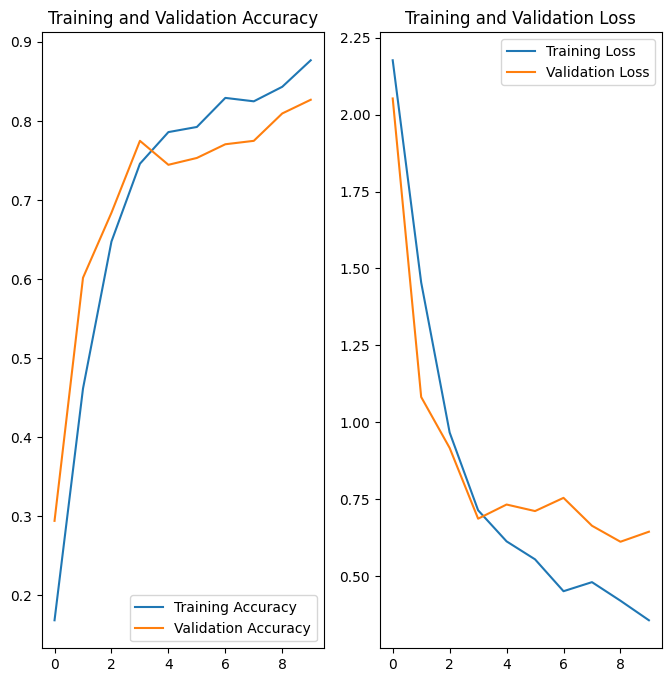

In [71]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [72]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

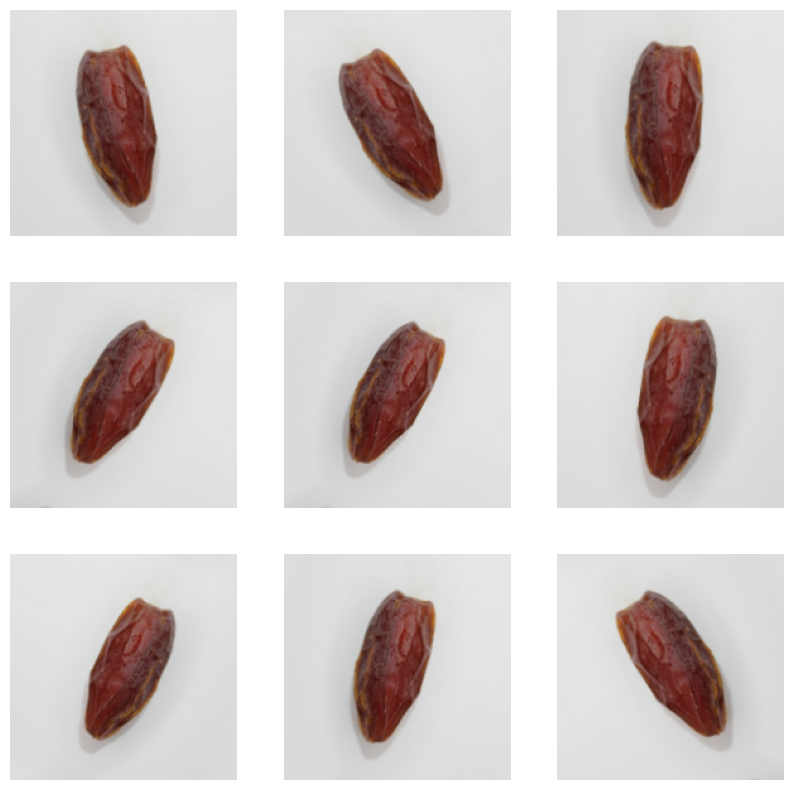

In [73]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [74]:
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, name="outputs")
])


In [75]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [76]:
model.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_8 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_10 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                 

In [77]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
29/29 [==============================] - 16s 433ms/step - loss: 2.4569 - accuracy: 0.1838 - val_loss: 2.0713 - val_accuracy: 0.2597
Epoch 2/15
29/29 [==============================] - 13s 457ms/step - loss: 1.9320 - accuracy: 0.2876 - val_loss: 1.6201 - val_accuracy: 0.3810
Epoch 3/15
29/29 [==============================] - 13s 434ms/step - loss: 1.6961 - accuracy: 0.3546 - val_loss: 1.7031 - val_accuracy: 0.2987
Epoch 4/15
29/29 [==============================] - 16s 564ms/step - loss: 1.5078 - accuracy: 0.4411 - val_loss: 1.3830 - val_accuracy: 0.4416
Epoch 5/15
29/29 [==============================] - 16s 537ms/step - loss: 1.3760 - accuracy: 0.4746 - val_loss: 1.4399 - val_accuracy: 0.4632
Epoch 6/15
29/29 [==============================] - 15s 514ms/step - loss: 1.2691 - accuracy: 0.5373 - val_loss: 1.2938 - val_accuracy: 0.4675
Epoch 7/15
29/29 [==============================] - 14s 491ms/step - loss: 1.1306 - accuracy: 0.5795 - val_loss: 1.0012 - val_accuracy: 0.6970

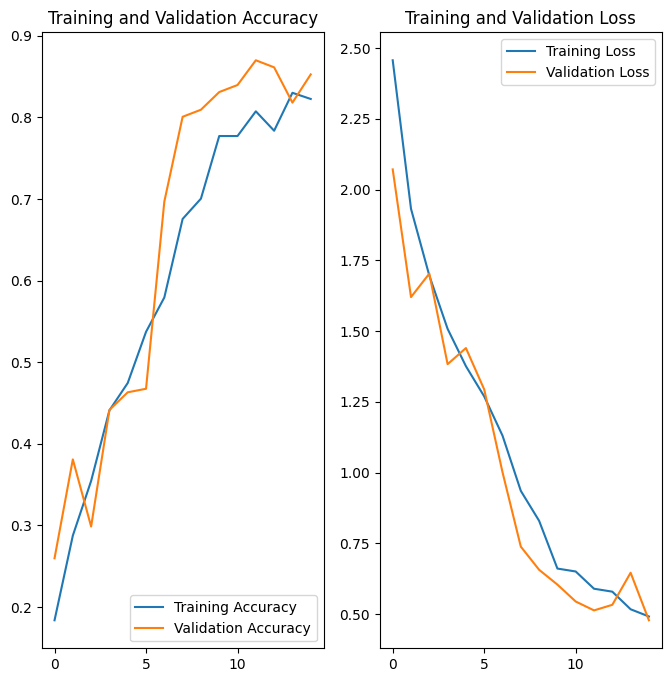

In [78]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [13]:
import os
allDir = []
rootdir = './test/'
for file in os.listdir(rootdir):
    d = os.path.join(rootdir, file)
    if os.path.isdir(d):
        x =d.split('/')
        print(f'{x[-1]} => {len(os.listdir(d))}')

Ajwa => 53
Galaxy => 57
Medjool => 41
Meneifi => 70
NabtatAli => 54
Rutab => 44
Shaishe => 52
Sokari => 80
Sugaey => 51


In [14]:
import os
allDir = []
rootdir = './train/'
for file in os.listdir(rootdir):
    d = os.path.join(rootdir, file)
    if os.path.isdir(d):
        x =d.split('/')
        print(f'{x[-1]} => {len(os.listdir(d))}')

Ajwa => 122
Galaxy => 133
Medjool => 94
Meneifi => 162
NabtatAli => 123
Rutab => 102
Shaishe => 119
Sokari => 184
Sugaey => 117


In [80]:
for i in allDir:
    arr = []
    arr = os.listdir(i)
    for j in arr:
        # print(i+j)
        try:
            img = tf.keras.utils.load_img(
                i+"/"+j, target_size=(img_height, img_width)
            )
            img_array = tf.keras.utils.img_to_array(img)
            img_array = tf.expand_dims(img_array, 0) # Create a batch

            predictions = model.predict(img_array)
            score = tf.nn.softmax(predictions[0])

            print(
                "This image most likely belongs to {} with a {:.2f} percent confidence."
                .format(class_names[np.argmax(score)], 100 * np.max(score))
            )
        except:
            print("Error" + i +"/"+ j)


1/1 [==============================] - 0s 93ms/step
This image most likely belongs to Ajwa with a 100.00 percent confidence.
1/1 [==============================] - 0s 28ms/step
This image most likely belongs to Ajwa with a 100.00 percent confidence.
1/1 [==============================] - 0s 29ms/step
This image most likely belongs to Ajwa with a 100.00 percent confidence.
1/1 [==============================] - 0s 28ms/step
This image most likely belongs to Ajwa with a 100.00 percent confidence.
1/1 [==============================] - 0s 27ms/step
This image most likely belongs to Ajwa with a 99.99 percent confidence.
1/1 [==============================] - 0s 29ms/step
This image most likely belongs to Ajwa with a 100.00 percent confidence.
1/1 [==============================] - 0s 28ms/step
This image most likely belongs to Ajwa with a 100.00 percent confidence.
1/1 [==============================] - 0s 28ms/step
This image most likely belongs to Ajwa with a 99.99 percent confidence.
1/

In [81]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\ahmad\AppData\Local\Temp\tmp3_6gitit\assets


INFO:tensorflow:Assets written to: C:\Users\ahmad\AppData\Local\Temp\tmp3_6gitit\assets


Text(0.5, 1.0, 'Number of images per class in training set')

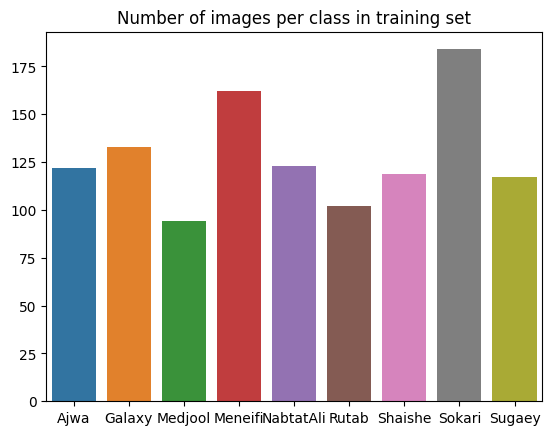

In [5]:
import os
import seaborn as sns
classesNambers = []
ourClasses = []
rootdir = './train/'
for file in os.listdir(rootdir):
    d = os.path.join(rootdir, file)
    if os.path.isdir(d):
        x =d.split('/')
        # print(f'{x[-1]} => {len(os.listdir(d))}')
        classesNambers.append(len(os.listdir(d)))
        ourClasses.append(x[-1])

sns.barplot(x=ourClasses, y=classesNambers).set_title('Number of images per class in training set')

Text(0.5, 1.0, 'Number of images per class in test set')

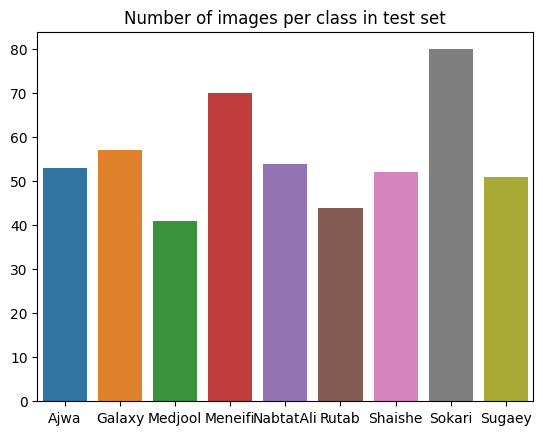

In [6]:
import os
classesNambers = []
ourClasses = []
rootdir = './test/'
for file in os.listdir(rootdir):
    d = os.path.join(rootdir, file)
    if os.path.isdir(d):
        x =d.split('/')
        # print(f'{x[-1]} => {len(os.listdir(d))}')
        classesNambers.append(len(os.listdir(d)))
        ourClasses.append(x[-1])

sns.barplot(x=ourClasses, y=classesNambers).set_title('Number of images per class in test set')